- KEYWORDS: Gaussian process


## Gaussian Process Regression



An alternative approach to data-driven models is Gaussian Process Regression. It is so different from the other kinds of regression we have done so far that we will need to take some time unraveling what it is and how to use it. First we briefly review what we have done so far.



### Regular regression - models with parameters



Most of what we have done is use models (e.g. a line, polynomial, exponential, etc.) with parameters in them that we fit to some data. We often can interpret those parameters in meaningful ways, e.g. the slope of the line, or a rate constant, etc. We worked out a way to estimate the uncertainty of the parameters, and it is possible to propagate that uncertainty to predictions of the model.



### Machine learning regression - flexible models with parameters



We expanded our thinking of models, and developed a way to build very flexible models that could be nonlinear, and that had a lot of adjustable parameters. These parameters were still found by fitting, e.g. minimizing the summed squared errors, to data. We gave up the interpretability of the parameters in favor of the flexibility to fit the data.



### Interpolation schemes



We also considered a few interpolating schemes. In these schemes, you assume some functional form exists between data points, locally fit the data, and then use the local fit to make predictions about intermediate points. Typical functional forms are linear, quadratic or cubic splines.



### Gaussian process regression (GPR)



GPR is somewhat intermediate in these ideas: It is like an interpolation scheme in the sense that we will make estimates of new points as weighted sums of known points. The weights, however, will be computed by an assumed model that has some parameters in it that must be fitted. These parameters are usually not directly meaningful though.

There is a substantial history and mathematical foundation behind GPR. In this lecture we will take a very practical approach based on some definitions for GPR. This will have the benefit that at the end you will know what it is and how to do it, but not where the definitions come from. That is not necessary to understand what is done, but if you are interested, here are some resources for learning more.

Automatic Model Construction with Gaussian Processes - David Duvenaud PhD thesis
[https://www.cs.toronto.edu/~duvenaud/thesis.pdf](https://www.cs.toronto.edu/~duvenaud/thesis.pdf)

Gaussian Processes for Machine Learning
[http://www.gaussianprocess.org/gpml/chapters/RW.pdf](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)



## GPR by example



Let's start with a goal, which is given some set of data points $x_i, y_i$ we would like to predict the value of $y*$ at some new point $x*$, and we would like that prediction to have the form of $y* = \sum_i w_i y_i$. That is we want the predicted value to be a weighted sum of the known points.  The key challenge is how to compute those weights.

To motivate why this is a reasonable idea, recall the idea behind Gaussian quadrature for integrals ([https://en.wikipedia.org/wiki/Gaussian_quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)): we can compute the value of an integral as the weighted sum of a few special points. The integral is a kind of function, and surely if those special points were among our data points, we could just weight all the other points by 0 and achieve this goal.

Alternatively, consider how you might estimate it in your head. You would look at the data, and use points that are close to the data point you want to estimate to form the estimate. Points that are far from the data point would have less influence on your estimate. You are implicitly weighting the value of the known points in doing this. In GPR we make this idea quantitative.

The key concept to quantify this is called *covariance*, which is how are two variables correlated with each other. Intuitively, if two x-values are close together, then we anticipate that the corresponding $f(x$ values are also close together. We can say that the values "co-vary", i.e. they are not independent. We use this fact when we integrate an ODE and estimate the next point, or in root solving when we iteratively find the next steps. We will use this idea to compute the weights that we need. The covariance is a matrix and each element of the matrix defines the covariance between two data points. To compute this, *we need to make some assumptions* about the data. A common assumption is that the covariance is Gaussian with the form:

$K_{ij} = \sigma_f \exp\left(-\frac{(x_i - x_j)^2}{2 \lambda^2}\right)$

In this equation, $\sigma_f$ and $\lambda$ are called *hyperparameters* and we have to determine what are good values for them. $\sigma_f$ is a scale factor, and $\lambda$ is a length scale. With this formula, data points with a distance of $2\lambda$ away from the point of interest have low (near zero) covariance with that point. In other words, only data points within $2\lambda$ distance units of a point will contribute to our estimate for that point.



# Out [148]:
# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

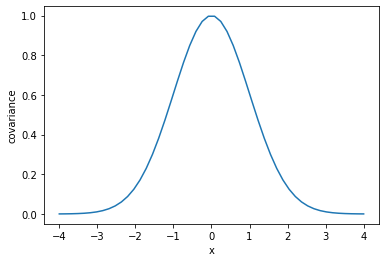

In [1]:
import numpy as np

sigmaf = 1.0
_lambda = 1.0

x0 = 0.0
x = np.linspace(-4, 4)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, sigmaf * np.exp(-(x0 - x)**2 / (2 * _lambda**2)))
plt.xlabel('x')
plt.ylabel('covariance');

So, what we need is a convenient way to compute the covariance between the points we know, and the points we want to estimate. To keep things simple for now, we consider a small data set. We need to be able to compute the distance from each known $x_i$ to each known $x_j$. Numpy array broadcasting makes this simple. We *expand* each array, and then take the difference.



In [1]:
X = np.linspace(0, 1, 3)
y = X**(1/3) + np.random.normal(0,  0.01, len(X)) # we add a little noise

Xp = np.array([0.45, 0.55])

dX = X[:, None] - X[None, :]
dX

# Out [184]:
# text/plain
array([[ 0. , -0.5, -1. ],
       [ 0.5,  0. , -0.5],
       [ 1. ,  0.5,  0. ]])

First, we get the covariance array for *the known x-values*. We have to make some choices for the hyperparameters. We will return to how to do this later. For now, we use these values because they work. We also add at this point the possibility that there is some noise in our data, which is characterized by a normal distribution with a mean of 0, and a spread of $\sigma_n$.



In [1]:
sigma_f = 1
lam = 0.15
sigma_n = 0.01

K1 = sigma_f * np.exp(-dX**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
K1

# Out [185]:
# text/plain
array([[1.00010000e+00, 3.86592014e-03, 2.23363144e-10],
       [3.86592014e-03, 1.00010000e+00, 3.86592014e-03],
       [2.23363144e-10, 3.86592014e-03, 1.00010000e+00]])

Next, we get the covariance of the *values of x we want to predict* and the known x-values. Note here we do not include the noise.



In [1]:
K2 = sigma_f * np.exp(-(Xp[:, None] - X[None, :])**2 / (2 * lam**2))
K2

# Out [186]:
# text/plain
array([[0.011109  , 0.94595947, 0.00120386],
       [0.00120386, 0.94595947, 0.011109  ]])

The first definition that we need is:

$\mathbf{w} = K(X*, X) \cdot [K(X, X) + \sigma_n^2 \mathbf{I}]^{-1}$

Here, $\sigma_n$ is a constant that represents noise. It can be zero, but during fitting it is helpful for it to be non-zero to avoid ill-conditioned matrices.



In [1]:
w = K2 @ np.linalg.inv(K1)
w

# Out [187]:
# text/plain
array([[ 0.00745169,  0.94584556, -0.00245246],
       [-0.00245246,  0.94584556,  0.00745169]])

Those weights mean that the middle data point contributes the most to the estimate, and the others hardly contribute.

To make an estimate with these weights, we use this second definition:

$y* = \mathbf{w} \cdot \mathbf{y}$



In [1]:
yp = w @ y
yp

# Out [188]:
# text/plain
array([0.74207029, 0.75186518])

Let's see how well we did.



# Out [189]:
# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

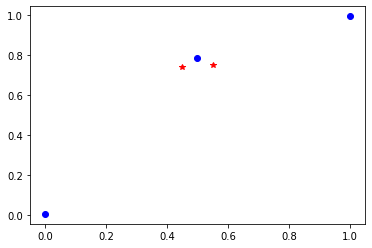

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X, y, 'bo')
plt.plot(Xp, yp, 'r*')

That is not bad, but clearly not great. With a $\lambda=0.15$, only one data point is contributing to the estimate, the other points have only small contributions because they are far from points we are estimating. This is a feature of the *assumption* we made about the covariance with $\lambda$. This means we do not have enough data to make a very good estimate. We can see this if we try this with a much more dense data set.



# Out [192]:
# output
Known data step size is 0.05

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

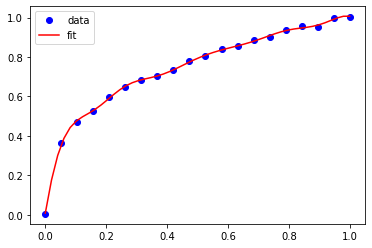

In [1]:
X, h = np.linspace(0, 1, 20, retstep=True)
y = X**(1/3) + np.random.normal(0, 0.01, len(X))

xp = np.linspace(0, 1.0, 50)

sigma_n = 0.01
sigma_f = 1
lam = 0.15

K1 = sigma_f * np.exp(-(X[None, :] - X[:, None])**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
Kp = sigma_f * np.exp(-(X[None, :] - xp[:, None])**2 / (2 * lam**2))

yp = Kp @ np.linalg.inv(K1) @ y

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X, y, 'bo')
plt.plot(xp, yp, 'r-')
plt.legend(['data', 'fit'])
print(f'Known data step size is {h:1.2f}')

Now you can see that we do very well in estimating the values. The length scale here might even be considered too short, since it is evident we are fitting trends in the noise.

GPR is often called a kind of machine learning. Let's see if the GPR actually "learned" the data by testing it in extrapolation.



# Out [193]:
# output
Known data step size is 0.05

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

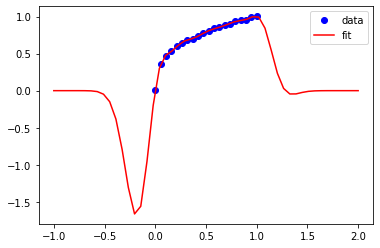

In [1]:
xp = np.linspace(-1, 2.0, 50)

sigma_f = 1
lam = 0.15

K1 = sigma_f * np.exp(-(X[:, None] - X[None, :])**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
Kp = sigma_f * np.exp(-(xp[:, None] - X[None, :])**2 / (2 * lam**2))

yp = Kp @ np.linalg.inv(K1) @ y

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X, y, 'bo')
plt.plot(xp, yp, 'r-')
plt.legend(['data', 'fit'])
print(f'Known data step size is {h:1.2f}')

As we saw with neural networks, GPRs do not extrapolate in a way that reflects the data. Eventually, in this case the result extrapolates to zero because of the Gaussian covariance function, but there are edge effects that are not desirable. As with Nns, we should be wary of extrapolation. We return to this in a later section.



### Underfitting in GPR



If you make the lengthscale too large then you over smooth the data, and don't fit any of them on average. This is underfitting, and it is not desirable because the estimates will not be good at new points. Note that you need some noise in the covariance array to make sure it is invertible in this case.



# Out [196]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

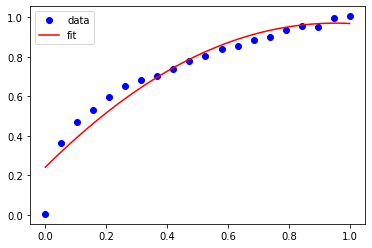

In [1]:
xp = np.linspace(0, 1.0, 50)

sigma_f, lam, sigma_n = 1, 3, 0.01

K1 = sigma_f * np.exp(-(X[:, None] - X[None, :])**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
Kp = sigma_f * np.exp(-(xp[:, None] - X[None, :])**2 / (2 * lam**2))

yp = Kp @ np.linalg.inv(K1) @ y

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X, y, 'bo')
plt.plot(xp, yp, 'r-')
plt.legend(['data', 'fit'])

### Overfitting in GPR



If you make the lengthscale too small, then you effectively fit every point, and have wiggles between them. This is overfitting, and it is not desirable because you won't get a good estimate at new points.



# Out [197]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

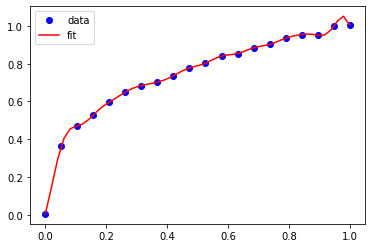

In [1]:
sigma_f, lam, sigma_n = 1, 0.05, 0.01

K1 = sigma_f * np.exp(-(X[:, None] - X[None, :])**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
Kp = sigma_f * np.exp(-(xp[:, None] - X[None, :])**2 / (2 * lam**2))

yp = Kp @ np.linalg.inv(K1) @ y

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X, y, 'bo')
plt.plot(xp, yp, 'r-')
plt.legend(['data', 'fit'])

### Finding the hyperparameters in GPR



You can see from the examples above that we have to choose some compromises in the hyperparameters. Some sets will underfit, and some will overfit. So, we need some principled way to estimate these. In conventional regression we would do this by minimizing an error function. In GPR, we use a different approach called *maximizing the log likelihood* of the parameters. This is a statistical concept, that is similar to minimizing the summed squared error, but different in that it is estimating the most likely average value of the hyperparameters. It is also must an optimization problem, that we formulate as:

$logp \approx -0.5 y K^{-1} y - 0.5 \log |K|$

The first term emphasizes fitting to the data, while the second term penalizes complexity. In this equation, $K$ depends on the hyperparameters, and we want to adjust these to maximize $logp$. Since we know something about the noise here, we fix that parameter, and adjust the other two parameters.

Given the original data, we now estimate the best hyperparameters and then predict other values.



# Out [198]:
# text/plain
array([1.        , 0.07626268])

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

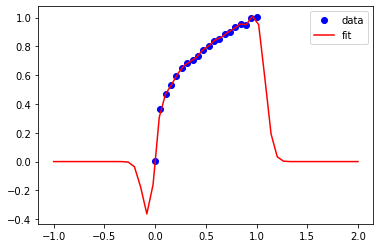

In [1]:
def log_likelihood(params):
    sigmaf, lam = params
    sigma_n = 0.01
    K = sigma_f * np.exp(-(X[:, None] - X[None, :])**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
    return -1*(-0.5 * y @ np.linalg.inv(K) @ y - 0.5 * np.log(np.diag(K)).sum())

xp = np.linspace(-1, 2.0, 50)

p = minimize(log_likelihood, [1, 0.05])
sigma_f, lam, sigma_n = (*p.x, 0.001)

K1 = sigma_f * np.exp(-(X[:, None] - X[None, :])**2 / (2 * lam**2)) + sigma_n**2 * np.eye(len(y))
Kp = sigma_f * np.exp(-(xp[:, None] - X[None, :])**2 / (2 * lam**2))

yp = Kp @ np.linalg.inv(K1) @ y

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X, y, 'bo')
plt.plot(xp, yp, 'r-')
plt.legend(['data', 'fit'])

p.x

Note that we still see some wiggles in the fit, indicating some minor degree of overfitting with the optimal hyperparameters. That is happening because we fit to all the data, and do not use any to estimate how good our fits are. You can use train/test data splits for GPR for this purpose as well, but it is out of the scope of the lecture today.

Also, note that the GPR doesn't *learn* the underlying function; it simply provides a weighted interpolation based on the covariance (assumed to be Gaussian) of neighboring points. The quality of the estimates depends on 1) the density of nearby points, and 2) whether Gaussian covariance is reasonable. When you have a lot of data that is close together, you can always get away with Gaussian covariance, but with small data sets of sparse points, it can be difficult to figure out reasonable hyperparameters. Also, Gaussian covariance does not extrapolate the way the underlying function here extrapolates.



## GPR Kernels



The function we used to compute the covariance arrays is called a *kernel*. It is in a way, a measure of similarity between two points. In the Gaussian kernel, we assume the similarity decays exponentially with the square of the distance between points, so that points that are more than a few lengthscales away are uncorrelated and have no information to contribute.

There are many other kinds of kernels, including linear and periodic kernels.

-   [https://peterroelants.github.io/posts/gaussian-process-kernels/](https://peterroelants.github.io/posts/gaussian-process-kernels/)
-   [https://www.cs.toronto.edu/~duvenaud/cookbook/](https://www.cs.toronto.edu/~duvenaud/cookbook/)

These kernels can be combined by multiplication and addition to form new kernels, allowing you to build sophisticated models for interpolating data.

Choosing a reasonable kernel is important, because it determines how well the model fits, and its extrapolation behavior (much like the activation functions in a NN).



### An example with a linear kernel



One definition of a linear kernel is

$k(x, x*) = \sigma_b^2 + \sigma_v^2 (x-c)(x_{*}-c)$.

There are three hyperparameters in this kernel, $\sigma_b, \sigma_v$ and $c$. None of these are easily interpreted as properties of the line though. Instead, they represent properties of a distribution of lines that fit the data. We do not care about this distribution directly, but rather about their mean value which is what we are predicting.

We will use this to fit some linear data in this example.



# Out [10]:
# text/plain
Text(0, 0.5, 'y')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

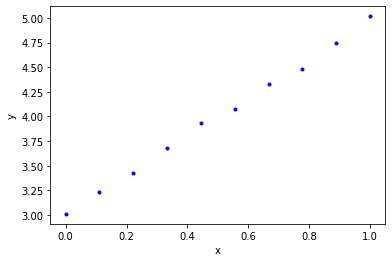

In [1]:
X = np.linspace(0, 1, 10)
y = 2 * X + 3 + np.random.normal(0, 0.05, len(X))

plt.plot(X, y, 'b.')
plt.xlabel('x')
plt.ylabel('y')

As before, we setup a log likelihood function and maximize it to get estimates for the parameters.



In [1]:
def LL(params):
    sb, sv, c = params
    K = sb**2 + sv**2 * (X - c)[:, None] * (X - c)[None, :]
    K += 0.05 * np.eye(len(y))
    return -1*(-0.5 * y @ np.linalg.inv(K) @ y - 0.5 * np.log(np.diag(K)).sum())

from scipy.optimize import minimize
p = minimize(LL, [3, 2, 0])
p

# Out [12]:
# text/plain
      fun: 7.441142858729776
 hess_inv: array([[ 5.57679533e+00, -3.56084049e-04,  4.71714899e-03],
       [-3.56084049e-04,  2.50591753e-02,  1.60216065e-02],
       [ 4.71714899e-03,  1.60216065e-02,  5.17836981e-02]])
      jac: array([ 5.18560410e-06,  0.00000000e+00, -4.05311584e-06])
  message: 'Optimization terminated successfully.'
     nfev: 190
      nit: 28
     njev: 38
   status: 0
  success: True
        x: array([ 3.03986249e-05,  6.33751040e-01, -1.51916463e+00])

And we can plot the function to see how well it does.



# Out [13]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

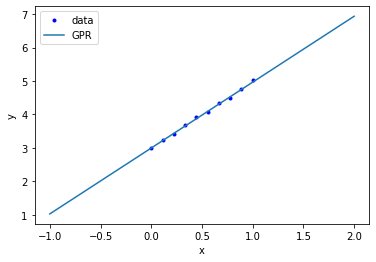

In [1]:
sb, sv, c = p.x

Xp = np.linspace(-1, 2)

K = sb**2 + sv**2 * (X - c)[:, None] * (X - c)[None, :]
K += 0.05 * np.eye(len(y))

Kp = sb**2 + sv**2 * (Xp - c)[:, None] * (X - c)[None, :]

yp = Kp @ np.linalg.inv(K) @ y

plt.plot(X, y, 'b.')
plt.plot(Xp, yp)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['data', 'GPR'])

Note that now, we get linear extrapolation, because we are using a linear kernel. Note also that the hyperparameters do not mean anything in particular to us. They do not include the slope or intercept. We can work those out pretty easily though. The intercept is just a prediction at $x=0$:



In [1]:
Kp = sb**2 + sv**2 * (np.array([0]) - c)[:, None] * (X - c)[None, :]

Kp @ np.linalg.inv(K) @ y

# Out [14]:
# text/plain
array([2.99568348])

Not surprisingly, the intercept is about 3.0. We can similarly compute the slope as rise/run since we have a line in our predictions, and it is also approximately what we expect.



In [1]:
(yp[-1] - yp[0]) / (Xp[-1] - Xp[0])

# Out [15]:
# text/plain
1.9719281419088903

#### Uncertainty quantification in GPR



One of the main reasons to use GPR is that you can estimate the uncertainty in predictions in a straightforward way. The covariance of a prediction is given by:

$\mathbf{\sigma} = K(X*, X*) - K(X*, X) [K(X, X) + \sigma_n^2 \mathbf{I}]^-1 K(X, X*)$

As we have done before, the square root of the diagonal is an estimate of the error in the prediction of each point.



:results:
  # Out [25]:


  # text/plain
  : <Figure size 432x288 with 1 Axes>

  # image/png
  
  :end:

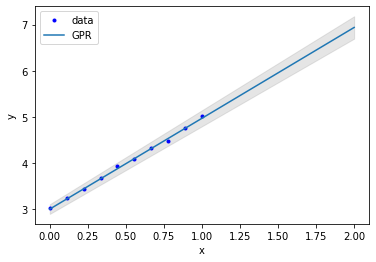

In [1]:
Xp = np.linspace(0, 2)
yp = Kp @ np.linalg.inv(K) @ y

K = sb**2 + sv**2 * (X - c)[:, None] * (X - c)[None, :]
K += 0.05 * np.eye(len(y))

Kp = sb**2 + sv**2 * (Xp - c)[:, None] * (X - c)[None, :]
Kt = sb**2 + sv**2 * (Xp - c)[:, None] * (Xp - c)[None, :]

sigma = np.sqrt(np.diag(Kt - Kp @ np.linalg.inv(K) @ Kp.T))

plt.plot(X, y, 'b.')
plt.plot(Xp, yp)
plt.fill_between(Xp, yp + 2*sigma, yp - 2*sigma, alpha=0.2, color='gray')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['data', 'GPR'])

### Combining kernels



Here we consider modeling a slowly increasing periodic function.



:results:
  # Out [223]:
  # text/plain
  : [<matplotlib.lines.Line2D at 0x112ff31d0>]

  # text/plain
  : <Figure size 432x288 with 1 Axes>

  # image/png
  
  :end:

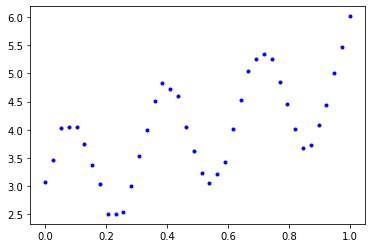

In [1]:
X = np.linspace(0, 1, 40)
y = 2 * X + 3 + np.sin(X * 20) + np.random.normal(0, 0.05, len(X))

plt.plot(X, y, 'b.')

This looks like a sin wave superimposed on a line. A periodic kernel is defined as

$k(x, x') = \sigma^2 \exp\left(-\frac{2 \sin^2(\pi|x - x'| / p)}{l^2}\right)$

$p$ is the periodicity and $l$ is the lengthscale. A key feature of GPR is you can add two kernel functions together and get a new kernel. Here we combine the linear kernel with the periodic kernel to represent data that is periodic and which increases (or decreases) with time.

As before we use the log likeliehood to find the hyperparameters that best fit this data.



In [1]:
def LL(params):
    sb, sv, c, sp, p, l = params
    K1 = sb**2 + sv**2 * (X - c)[:, None] * (X - c)[None, :]
    K2 = sp**2 * np.exp(-2 * np.sin(np.pi / p * np.abs((X[:, None] - X[None, :])))**2 / l**2)
    K = K1 + K2 + 0.05 * np.eye(len(y))
    return -1*(-0.5 * y @ np.linalg.inv(K) @ y - 0.5 * np.log(np.diag(K)).sum())

pars = minimize(LL, [3, 2, 0, 1, 1, 0.01])
pars

:results:
  # Out [250]:
  # text/plain
  :       fun: 21.64432997091645
  :  hess_inv: array([[ 0.02566004,  0.03295146,  0.03444588,  0.02119516, -0.00374442,
  :          0.01212218],
  :        [ 0.03295146,  0.15018953,  0.174288  ,  0.10898889, -0.01243345,
  :          0.02559436],
  :        [ 0.03444588,  0.174288  ,  0.20963766,  0.12009086, -0.01367912,
  :          0.02481981],
  :        [ 0.02119516,  0.10898889,  0.12009086,  0.09112471, -0.01038431,
  :          0.01929607],
  :        [-0.00374442, -0.01243345, -0.01367912, -0.01038431,  0.00145019,
  :         -0.00231033],
  :        [ 0.01212218,  0.02559436,  0.02481981,  0.01929607, -0.00231033,
  :          0.01164513]])
  :       jac: array([-1.90734863e-06, -1.19209290e-06,  6.19888306e-06,  4.05311584e-06,
  :        -9.77516174e-06,  3.57627869e-06])
  :   message: 'Optimization terminated successfully.'
  :      nfev: 520
  :       nit: 42
  :      njev: 65
  :    status: 0
  :   success: True
  :         x:

And we check how the fit looks, and how it extrapolates.



:results:
  # Out [251]:
  # text/plain
  : [<matplotlib.lines.Line2D at 0x1137cf128>,
  :  <matplotlib.lines.Line2D at 0x1137cf240>]

  # text/plain
  : <Figure size 432x288 with 1 Axes>

  # image/png
  
  :end:

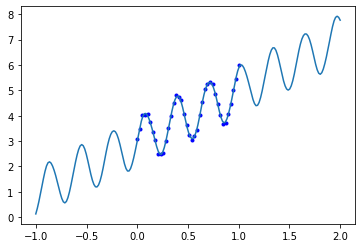

In [1]:
xp = np.linspace(-1, 2, 200)

sb, sv, c, sp, p, l = pars.x

K1 = sb**2 + sv**2 * (X - c)[:, None] * (X - c)[None, :]
K2 = sp**2 * np.exp(-2 * np.sin(np.pi / p * np.abs((X[:, None] - X[None, :])))**2 / l**2)
K = K1 + K2 + 0.05 * np.eye(len(y))

Kp1 = sb**2 + sv**2 * (xp - c)[:, None] * (X - c)[None, :]
Kp2 = sp**2 * np.exp(-2 * np.sin(np.pi / p * np.abs((xp[:, None] - X[None, :])))**2 / l**2)
Kp = Kp1 + Kp2


yp = Kp @ np.linalg.inv(K) @ y
plt.plot(X, y, 'b.', xp, yp)

Note that we get oscillatory + linear extrapolation behavior!



## Brief comparison of GPR and NN



GPR is called a non-parametric regression method. That is only partly true, there are hyperparameters that must be chosen in the kernels. In contrast, neural networks (and other physical models are called *parametric* models.

A key feature of GPR compared to other methods is that uncertainty estimates are a "built-in" feature, compared to parametric models where you might consider it an add-on feature that approximates the uncertainty. Although we say uncertainty analysis is built into to GPR, it also relies on some assumptions, e.g. that there is Gaussian noise in the data, and that the residual errors are Gaussian. If those are not true, then the uncertainty in a GPR is also an estimate.

For very large datasets GPR has a distinct disadvantage over neural networks. For $n$ data points covariance matrix is an $n \times n$, and we need the inverse of this array. Inverse calculations usually scale as $O(n^3)$ so this can get expensive fast. Even after that, however, you have to do several matrix multiplications, including an $m \times n$ covariance array, a $n \times n$ inverse covariance array and the $n \times 1$ array of known values. If is possible to compute one of these one time only, but for every prediction, one must compute the $m \times n$ covariance array every time.

In contrast, for neural networks, all the time is spent upfront on training. After that, all the arrays of weights are fixed, and the computational time for predictions is constant (and usually comparatively small).



## GPR libraries



In this lecture we have examined GPR in a hand's on, practical and manual way. In practice, it is rare to do this anymore as there are libraries that automate much of the calculations. Using these requires a sophisticated understanding of how GP works though, and they are not easy to start with.

-   **scikit-learn:** [https://scikit-learn.org/stable/modules/gaussian_process.html](https://scikit-learn.org/stable/modules/gaussian_process.html)
-   **Gpy:** [https://sheffieldml.github.io/GPy/>](https://sheffieldml.github.io/GPy/>)(pytorch)
-   **GPFlow:** [https://gpflow.readthedocs.io/en/latest/intro.html>](https://gpflow.readthedocs.io/en/latest/intro.html>)(Tensorflow)



## Summary



This lecture introduced GPR in a practical, by example way. There are formal ways to derive the equations we introduced, but they rely on a deep understanding of statistics that is beyond the scope of this class. These approaches provide a variety of insights to understand why GPR works, how it is related to other types of machine learning, etc.

